# Data extraction for AI application in Structural Engineering
_Larissa Driemeier, Izabel F. Machado and Gabriel Lopes Rodrigues_
 ![](https://drive.google.com/uc?export=view&id=1yQoXEcvbE4V4uTuP4jFyFvvlpCunZHVn)

This introductory notebook replicates the geometry of the structure analysed in the paper
[*Background Information of Deep Learning for Structural Engineering*](https://www.researchgate.net/publication/318190131_Background_Information_of_Deep_Learning_for_Structural_Engineering). 

It is based on the [PMR5251 - Class#3](https://edisciplinas.usp.br/pluginfile.php/5728638/mod_resource/content/1/Aula01_Introd_ML.pdf)


## Geometry

The figure below shows a beam like 2D truss with 10 bars. The length of the bars are fixed, however the cross sectional areas are obtained through a random uniform sampling between $0.6$ $cm^2$ and $225.8$ $cm^2$. In total, 500 different structures were generated.

 ![](https://drive.google.com/uc?export=view&id=1vcjpWzeJM_lSJYDQB3od1CF_UBnGeiZE)

Then, the structure is loaded and analysed in the commercial FE software Abaqus. Since the dimensions in the structure are fixed, the input the set of areas, while all nodal displacements and also bar stresses are computed as output.

## Linear material model 

The material characteristics are generic values for Aluminum alloy 6061, as listed below.

Property  | Value &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    | Unity&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
---   | --- | ---
Mass density $\rho$ | $2.768\times  10^{-9}$ | $ton/mm^2$
Poisson $\nu$ | $0.35$ | -
Young's Modulus $E$| $68950$ | $MPa$
Yield stress $\sigma_{y0}$| $200$ | $MPa$

The material undergoes elastic deformation until it reaches the elastic limit defined by the yield stress. After the elastic limit, the material exhibits plastic behavior,that is, the material deforms irreversibly and does not return to its original shape and size, even when the load is removed. Initially, only elastic behaviour is considered.

## Libraries
Throughout this notebook the new version 2.0 of Tersorflow was used, with built-in keras support, which has been recently released to the public.
To install it, just follow the instructions in [the official website](https://www.tensorflow.org/install), to guarantee that the right version is installed.

The rest of the libraries used were simply installed using pip, the default Python tool for installing packages. These include:

- NumPy: library for dealing with large matrices and also providing optimized functions for these data structures

- Pandas: used to visualize the data and to work with the dataset.

- matplotlib: used to generate plots from the models.

- sklearn (also known as scikit-learn): used because of the many useful functions and utilities it provides for machine learning.

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
from tensorflow import keras
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

## Data Loading and Manipulation

Uploading four files:
1. the dataset containing the areas, `areas.csv`;
2. displacements and reaction force along the time, `FinalResult.csv`;

If you prefer generate new data, we suggest to use the student version of the software [Abaqus](https://edu.3ds.com/en/software/abaqus-student-edition). The following files are available in the same [link](https://edisciplinas.usp.br/course/view.php?id=82602#section-3):
 1. To generate random areas `gera_areas_10.py`;
 2. Script to run in Abaqus to generate data `10_bar_truss.py`;
 3. Basic geometry to be called by the script mentioned in item 2 `Job-10-bar.inp`;
 4. Copy the file `extracted_data_DATA_HOUR.csv` as `FinalResult.csv` to upload.

 **Importante**

O script do item 02 gera automaticamente a geometria de barras no Abaqus. Caso você queira montar uma geometria - pelo menos uma vez - no Abaqus, o Prof Marcilio Alves, gentilmente, preparou um tutorial por nós no [link](https://www.youtube.com/channel/UCEDn-UheEHKLfOKJKmSKzJw). 


In [5]:
from google.colab import files
uploaded = files.upload()

Saving areas.csv to areas.csv
Saving FinalResult.csv to FinalResult.csv


As shown below, there are 10 different areas, which will be the inputs, and various other measurements, which might be used as outputs of the Neural Network

In [7]:
df = pd.read_csv('FinalResult.csv', index_col=0)

In [8]:
df.dtypes

area1       float64
area2       float64
area3       float64
area4       float64
area5       float64
area6       float64
area7       float64
area8       float64
area9       float64
area10      float64
d1          float64
d2          float64
d3          float64
d4          float64
d5          float64
d6          float64
d7          float64
d8          float64
s11_1       float64
s11_2       float64
s11_3       float64
s11_4       float64
s11_5       float64
s11_6       float64
s11_7       float64
s11_8       float64
s11_9       float64
s11_10      float64
mises_1     float64
mises_2     float64
mises_3     float64
mises_4     float64
mises_5     float64
mises_6     float64
mises_7     float64
mises_8     float64
mises_9     float64
mises_10    float64
dtype: object

In [9]:
# To show all the columns
pd.set_option('display.max_columns', None)
df.head()

area1     area2     area3     area4     area5     area6  \
iteration                                                               
0          0.003086  0.019144  0.017260  0.005804  0.011217  0.010183   
1          0.018881  0.009806  0.017227  0.000107  0.010090  0.016309   
2          0.000633  0.012253  0.021210  0.008645  0.004938  0.009566   
3          0.005309  0.005259  0.004987  0.010410  0.006586  0.000544   
4          0.022412  0.019426  0.002782  0.007552  0.016308  0.016076   

              area7     area8     area9    area10         d1          d2  \
iteration                                                                  
0          0.014734  0.017822  0.002174  0.000698  10.579137  -70.774597   
1          0.005212  0.021347  0.020360  0.000749   9.366341 -245.959854   
2          0.000714  0.005052  0.009921  0.011226  41.207355 -185.375214   
3          0.018922  0.012591  0.014524  0.004247   9.551858  -69.896049   
4          0.021149  0.009566  0.018752  0.015155   9.622062  -46.439331   

                  d3          d4         d5         d6         d7         d8  \
iteration                                                                      
0         -24.355942  -71.550392   6.575743 -16.113703  -8.060376 -16.891342   
1         -17.619713 -251.032944   6.852213 -21.184267 -17.206579 -26.058153   
2         -96.529587 -193.678513  37.074791 -54.188625 -68.113937 -65.723526   
3         -15.171593  -72.082794   8.560319 -36.236866  -6.773345 -43.978748   
4          -8.717741  -48.590137   7.751640 -23.164854  -7.650749 -22.620508   

                 s11_1        s11_2       s11_3       s11_4        s11_5  \
iteration                                                                  
0         -122876112.0   5863760.00  30187446.0   5849860.5  -60778972.0   
1           -3115212.0  36751352.00  18957688.0  38253380.0 -129745584.0   
2         -214267184.0  86978520.00  31161468.0  62610644.0 -513610688.0   
3          -63326688.0  58377396.00   7476665.0  16489037.0  -51074160.0   
4           -8045611.0  -4104622.75  14103846.0  16218065.0  -57690196.0   

                 s11_6        s11_7        s11_8        s11_9       s11_10  \
iteration                                                                    
0           49584148.0 -132877080.0   33294788.0  -35960320.0   92389552.0   
1           51668864.0 -728894336.0   33372482.0  -54035168.0  774317952.0   
2          279561120.0  -38947984.0   -9012399.0  -64523128.0   22189706.0   
3           64548776.0  -36164440.0  140273008.0 -104346992.0   45672644.0   
4           58450960.0  -24679984.0   56439460.0  -58111388.0   33765824.0   

               mises_1      mises_2     mises_3     mises_4      mises_5  \
iteration                                                                  
0          122876112.0   5863760.00  30187446.0   5849860.5   60778972.0   
1            3115212.0  36751352.00  18957688.0  38253380.0  129745584.0   
2          214267184.0  86978520.00  31161468.0  62610644.0  513610688.0   
3           63326688.0  58377396.00   7476665.0  16489037.0   51074160.0   
4            8045611.0   4104622.75  14103846.0  16218065.0   57690196.0   

               mises_6      mises_7      mises_8      mises_9     mises_10  
iteration                                                                   
0           49584148.0  132877080.0   33294788.0   35960320.0   92389552.0  
1           51668864.0  728894336.0   33372482.0   54035168.0  774317952.0  
2          279561120.0   38947984.0    9012399.0   64523128.0   22189706.0  
3           64548776.0   36164440.0  140273008.0  104346992.0   45672644.0  
4           58450960.0   24679984.0   56439460.0   58111388.0   33765824.0

### Splitting dataset

The whole dataset will be split into training and test sets. The training set will be used to train the model and the test set to verify its performance.





In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=1)

In [12]:
train.head()

area1     area2     area3     area4     area5     area6  \
iteration                                                               
201        0.020959  0.005235  0.019197  0.010005  0.020077  0.002349   
92         0.022529  0.005868  0.011631  0.016714  0.015629  0.009822   
344        0.003219  0.012311  0.017884  0.016157  0.003217  0.021146   
119        0.015217  0.020134  0.003938  0.014535  0.011037  0.007739   
221        0.000490  0.002986  0.006551  0.010698  0.000663  0.001572   

              area7     area8     area9    area10         d1          d2  \
iteration                                                                  
201        0.001271  0.010606  0.021014  0.010539  16.004036 -120.325661   
92         0.017558  0.011000  0.016172  0.011126  12.547656  -53.592022   
344        0.021048  0.008138  0.022080  0.004350  14.224157  -54.255360   
119        0.016059  0.022021  0.000548  0.020267  18.363760  -50.452175   
221        0.017995  0.022135  0.009766  0.010640   8.433659  -77.570465   

                  d3          d4         d5         d6         d7         d8  \
iteration                                                                      
201       -53.915527 -120.185944  16.137526 -32.663422 -50.967178 -54.107288   
92         -8.100519  -54.670982  11.504974 -27.936739  -6.230652 -30.526878   
344       -18.496674  -60.128796  13.368400 -21.245007  -6.041500 -21.704147   
119       -12.587241  -51.165943   3.985027 -24.647602  -9.228423 -21.760574   
221       -70.816208 -118.827141   5.633955 -34.009995  -6.182016 -55.686005   

                 s11_1         s11_2         s11_3         s11_4        s11_5  \
iteration                                                                       
201        -22231914.0  1.616967e+08 -1.006564e+06 -1.053551e+06 -384316160.0   
92         -14099667.0  1.953085e+07  7.862298e+06  8.135870e+06  -46982004.0   
344        -93917784.0  3.462124e+06  6.452812e+06  4.428844e+07  -45555708.0   
119        -25327046.0 -2.176952e+07  1.084223e+08  5.382156e+06  -69586584.0   
221       -487371776.0  1.634472e+08  2.111106e+07  3.110945e+08  -46615268.0   

                 s11_6        s11_7        s11_8        s11_9      s11_10  \
iteration                                                                   
201        121684416.0   2838388.50   11838953.0  -62306460.0  65863956.0   
92          86752840.0 -16162369.00   91602400.0  -61951560.0  26877044.0   
344        100803928.0 -46319392.00   59051812.0  -29696636.0  26462190.0   
119         30048950.0  -4145055.75   47249120.0  -77902696.0  37499008.0   
221         42482636.0 -27404998.00  186641504.0 -106984240.0  31545470.0   

               mises_1       mises_2       mises_3       mises_4      mises_5  \
iteration                                                                       
201         22231914.0  1.616967e+08  1.006564e+06  1.053551e+06  384316160.0   
92          14099667.0  1.953085e+07  7.862298e+06  8.135870e+06   46982004.0   
344         93917784.0  3.462124e+06  6.452812e+06  4.428844e+07   45555708.0   
119         25327046.0  2.176952e+07  1.084223e+08  5.382156e+06   69586584.0   
221        487371776.0  1.634472e+08  2.111106e+07  3.110945e+08   46615268.0   

               mises_6      mises_7      mises_8      mises_9    mises_10  
iteration                                                                  
201        121684416.0   2838388.50   11838953.0   62306460.0  65863956.0  
92          86752840.0  16162369.00   91602400.0   61951560.0  26877044.0  
344        100803928.0  46319392.00   59051812.0   29696636.0  26462190.0  
119         30048950.0   4145055.75   47249120.0   77902696.0  37499008.0  
221         42482636.0  27404998.00  186641504.0  106984240.0  31545470.0

In [ ]:
train.shape, test.shape

((416, 38), (104, 38))

### Defining the training values and the expected outputs

The input for the NN is a vector with all 10 areas that compound the geometry of the structure. Remember that we mantain all other parameters, such as material properties and dimensions, fixed.

As output for the NN, let's generate an array of displacements (\[*d2*, *d4*\]). These correspond to the vertical displacements of the rightmost nodes of the structure.


In [ ]:
x_train = train.loc[:,'area1':'area10'].values
y_train = train[['d2', 'd4']].values
x_test = test.loc[:,'area1':'area10'].values
y_test = test[['d2', 'd4']].values

### FEA results

Read the results from FEA, where `d2` and `d4` are the displacements at the rightmost nodes of the structure to see the variation our future NN has to learn.

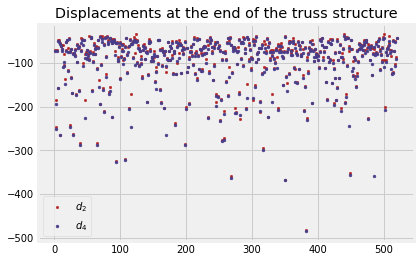

In [ ]:
disp2 = df[['d2']].values
disp4 = df[['d4']].values
xAxis = [i + 1.0 for i, _ in enumerate(disp2)]
plt.scatter(xAxis,disp2,color='firebrick',s=6, label =r'$d_2$')
plt.scatter(xAxis,disp4,color='darkslateblue',s=8, label =r'$d_4$')
plt.title('Displacements at the end of the truss structure')
plt.legend()
plt.show()

### Normalizing Dataset

As the paper has done, the input data was normalized, to obtain better results.

The normalizer of the sklearn library was used to facilitate the process.

In [ ]:
from sklearn import preprocessing

normalizer = preprocessing.StandardScaler().fit(x_train)
x_train_norm = normalizer.transform(x_train)
x_test_norm = normalizer.transform(x_test)

As can be seen below, the mean and standard deviation for the training set are, respectively, approximately 0 and 1. Since the dataset is normalized with respect to the training set, 
for the test data the mean and standard deviation are, in this case, slightly different.

In [ ]:
# Mean
mean_train = np.mean(x_train_norm)
mean_test = np.mean(x_test_norm)

# Standard Deviation
std_train = np.std(x_train_norm)
std_test = np.std(x_test_norm)

print('For the training set, the mean is {:2.4f} and the standard deviation is {:2.4f}'.format(mean_train,std_train))
print('For the test set, the mean is {:2.4f} and the standard deviation is {:2.4f}'.format(mean_test,std_test))


For the training set, the mean is -0.0000 and the standard deviation is 1.0000
For the test set, the mean is -0.0043 and the standard deviation is 0.9993
